This notebook implements the Metric Learning with Triplet Margin Loss for parameter-efficient fine-tuning of the DINOv2 backbone.

Key Improvements over the baseline:
- A custom `PlantDataset` class handles smart augmentations separately for herbarium and field domains.
- Triplet Margin Loss with semi-hard mining to reduce intra-class distance across domain.
- Extracted embeddings used on KNN classifiers with Test-Time Augmentation (TTA) to improve accuracy.

# 1.0 Environment Setup

## 1.1 Install Libraries

In [1]:
!pip install timm
!pip install kagglehub
!pip install pytorch-metric-learning

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1.2 Import Libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

# Computer Vision
import torchvision.transforms as T
import timm # Required for DINOv2 backbone
import kagglehub # Needed for model loading

# Metric Learning
from pytorch_metric_learning import losses, miners

# Classification & Evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split

## 1.3 Define Constants and Check GPU Availability

In [3]:
# --- Configuration Constants ---
BASE_DIR = os.getcwd() 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Model & Training Parameters
EMBEDDING_DIM = 256  # Size of the final embedding space
BATCH_SIZE = 60
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
MARGIN = 0.5         # Margin for TripletMarginLoss

# NEW: LoRA Parameters
LORA_RANK = 4        # r: Rank of the low-rank matrices (4 or 8 is common)
LORA_ALPHA = 8       # alpha: Scaling factor (often 2*r)

# DINOv2 Backbone (ViT-B/14)
DINOV2_MODEL_NAME = 'vit_base_patch14_reg4_dinov2.lvd142m'
INPUT_SIZE = 224
DINOV2_FEATURES = 768 # Feature size before the embedding head

# Validation Split Ratio
VALIDATION_SPLIT_RATIO = 0.2

Using device: cuda


# 2.0 Load Files

In [4]:
def load_data_lists(base_dir, val_split_ratio):
    """Loads all necessary path/label mappings and splits the data into train/val/test."""
    
    list_dir = os.path.join(base_dir, 'list')

    # 1. Training data (path, class_id)
    train_data = []
    with open(os.path.join(list_dir, 'train.txt'), 'r') as f:
        for line in f:
            path, class_id = line.strip().split()
            domain = 'herbarium' if 'herbarium' in path else 'field'
            full_image_path = os.path.join(base_dir, path)
            train_data.append({'path': full_image_path, 
                               'class_id': int(class_id), 
                               'domain': domain})
    full_train_df = pd.DataFrame(train_data)
    
    # 2. Test Ground Truth (path, class_id)
    test_data = []
    with open(os.path.join(list_dir, 'groundtruth.txt'), 'r') as f:
        for line in f:
            path, class_id = line.strip().split()
            full_image_path = os.path.join(base_dir, path)
            test_data.append({'path': full_image_path, 
                              'class_id': int(class_id), 
                              'domain': 'field'})
    test_df = pd.DataFrame(test_data)
    
    # 3. Class grouping lists
    def load_class_ids(filename):
        with open(os.path.join(list_dir, filename), 'r') as f:
            return {int(line.strip()) for line in f}

    with_pairs_classes = load_class_ids('class_with_pairs.txt')
    without_pairs_classes = load_class_ids('class_without_pairs.txt')

    # --- Splitting logic for validation set ---
    train_herbarium_only_df = full_train_df[full_train_df['class_id'].isin(without_pairs_classes)].copy()
    train_with_pairs_df = full_train_df[full_train_df['class_id'].isin(with_pairs_classes)].copy()
    
    train_split_df, val_df = train_test_split(
        train_with_pairs_df,
        test_size=val_split_ratio,
        stratify=train_with_pairs_df['class_id'],
        random_state=42 
    )
    
    train_df = pd.concat([train_herbarium_only_df, train_split_df], ignore_index=True)
    
    print(f"Loaded {len(full_train_df)} total training samples across {full_train_df['class_id'].nunique()} species.")
    print(f"Split into {len(train_df)} training samples and {len(val_df)} validation samples.")
    print(f"Loaded {len(test_df)} test samples.")
    print(f"Species with pairs (validation candidates): {len(with_pairs_classes)}")
    print(f"Species without pairs (herbarium-only training): {len(without_pairs_classes)}")
    
    return train_df, val_df, test_df, with_pairs_classes, without_pairs_classes

# Load all data upfront
TRAIN_DF, VAL_DF, TEST_DF, WITH_PAIRS_CLASSES, WITHOUT_PAIRS_CLASSES = load_data_lists(BASE_DIR, VALIDATION_SPLIT_RATIO)

# Map original class IDs to 0-based integers for PyTorch compatibility
ALL_SPECIES = sorted(TRAIN_DF['class_id'].unique())
CLASS_TO_IDX = {class_id: idx for idx, class_id in enumerate(ALL_SPECIES)}
IDX_TO_CLASS = {idx: class_id for class_id, idx in CLASS_TO_IDX.items()} # NEW: Reverse mapping
NUM_CLASSES = len(ALL_SPECIES)

print(f"Mapped {NUM_CLASSES} species to 0-based indices.")

Loaded 4744 total training samples across 100 species.
Split into 4144 training samples and 600 validation samples.
Loaded 207 test samples.
Species with pairs (validation candidates): 60
Species without pairs (herbarium-only training): 40
Mapped 100 species to 0-based indices.


# 3.0 Smart Augmentation Strategy

In [5]:
# --- 3. Smart Augmentation Definition ---

# Base transforms for all images
BASE_TRANSFORM = T.Compose([
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3a. Herbarium Augmentation (Simulate Field Conditions)
HERBARIUM_AUGMENT = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.8, 1.0)), # Random Cropping
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1), # Color Jitter
    T.RandomApply([T.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.3),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3b. Field Augmentation (Light Augmentations)
FIELD_AUGMENT = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.9, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10), # Random Rotations
    T.ColorJitter(brightness=0.1, contrast=0.1), # Lighting variation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3c. Inference/Test Transform (No Augmentation)
INFERENCE_TRANSFORM = BASE_TRANSFORM

# 4.0 Data Class and Preprocessing

## 4.1 Custom Dataset Class

In [6]:
# --- 4. Custom Dataset Class ---

class PlantDataset(Dataset):
    def __init__(self, dataframe, transform_h=None, transform_f=None, transform_inf=INFERENCE_TRANSFORM, is_train=True):
        self.dataframe = dataframe.copy()
        # Map original class IDs to PyTorch indices
        self.dataframe['idx_label'] = self.dataframe['class_id'].map(CLASS_TO_IDX)
        self.transform_h = transform_h
        self.transform_f = transform_f
        self.transform_inf = transform_inf # New argument
        self.is_train = is_train

        # Pre-process for Triplet Sampling (if training)
        if self.is_train:
            self.class_to_indices = defaultdict(list)
            for i, row in self.dataframe.iterrows():
                self.class_to_indices[row['idx_label']].append(i)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        path = row['path']
        label = row['idx_label']
        domain = row['domain']
        
        # Load image
        img = Image.open(path).convert('RGB')
        
        # Apply Smart Augmentation/Transform
        if self.is_train:
            if domain == 'herbarium' and self.transform_h is not None:
                image = self.transform_h(img)
            elif domain == 'field' and self.transform_f is not None:
                image = self.transform_f(img)
            else:
                image = BASE_TRANSFORM(img) # Fallback
        else:
            # Use inference transform for test/evaluation
            # For TTA, this will be dynamically changed, but for standard validation/test, this is fine
            image = self.transform_inf(img)

        # Return image, mapped label (idx_label), and original index
        return image, label, idx

# Initialize Datasets
train_dataset = PlantDataset(TRAIN_DF, 
                             transform_h=HERBARIUM_AUGMENT, 
                             transform_f=FIELD_AUGMENT, 
                             is_train=True)

# New: Validation Dataset (uses INFERENCE_TRANSFORM)
validation_dataset = PlantDataset(VAL_DF, is_train=False)

test_dataset = PlantDataset(TEST_DF, is_train=False)

## 4.2 Smart Triplet Sampler

In [7]:
# --- 5. Smart Triplet Sampler (Class-Balanced and Priority Sampling) ---

class SmartTripletSampler(Sampler):
    """
    Samples batches ensuring a class-balanced approach and prioritizing 
    'Herbarium-Only' species for balanced contribution.
    """
    def __init__(self, dataset, batch_size, num_triplets_per_epoch):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_triplets_per_epoch = num_triplets_per_epoch

        # Identify species groups by their mapped PyTorch indices
        self.all_classes = list(dataset.class_to_indices.keys())
        
        # Map original class IDs (from file) to PyTorch indices
        idx_with_pairs = {CLASS_TO_IDX[cid] for cid in WITH_PAIRS_CLASSES if cid in CLASS_TO_IDX}
        idx_without_pairs = {CLASS_TO_IDX[cid] for cid in WITHOUT_PAIRS_CLASSES if cid in CLASS_TO_IDX}

        self.priority_classes = list(idx_without_pairs) # Herbarium-Only species
        self.other_classes = list(idx_with_pairs) 

        # Create a weighted list of classes to sample:
        # Give higher probability to priority classes (e.g., 2:1 ratio)
        self.sampling_classes = (self.priority_classes * 2) + self.other_classes
        if not self.sampling_classes:
             self.sampling_classes = self.all_classes # Fallback

        # Check if batch size is suitable for triplet mining (min 2 samples per class)
        if self.batch_size % 3 != 0 or self.batch_size < 3:
             print("WARNING: BATCH_SIZE should be a multiple of 3 (e.g., 60, 63) for effective batch mining.")


    def __iter__(self):
        # We generate indices for 'num_triplets_per_epoch' triplets.
        
        # Use a list to store indices that will form the training batch
        all_indices = []
        
        # We need self.num_triplets_per_epoch * 3 total samples
        num_batches = int(np.ceil((self.num_triplets_per_epoch * 3) / self.batch_size))
        
        for _ in range(num_batches): 
            K = 8 # Number of classes per batch (Tune based on BATCH_SIZE)
            
            # Sample K classes using the weighted list
            sampled_classes = random.choices(self.sampling_classes, k=K)
            
            # 2. Sample N images from each selected class to form the batch
            batch_indices = []
            max_samples_per_class = self.batch_size // K # e.g. 64 / 8 = 8

            for c in sampled_classes:
                # Get all available indices for this class
                available_indices = self.dataset.class_to_indices[c]
                
                # Sample up to max_samples_per_class from this class (with replacement if needed)
                if len(available_indices) >= max_samples_per_class:
                    c_indices = random.sample(available_indices, max_samples_per_class)
                else:
                    # Sample with replacement if class is small
                    c_indices = random.choices(available_indices, k=max_samples_per_class)

                batch_indices.extend(c_indices)

            # Trim or pad the batch to ensure BATCH_SIZE
            if len(batch_indices) > self.batch_size:
                batch_indices = batch_indices[:self.batch_size]
            elif len(batch_indices) < self.batch_size:
                # Simple padding for simplicity, ideally we'd re-sample more classes
                padding_needed = self.batch_size - len(batch_indices)
                batch_indices.extend(random.choices(batch_indices, k=padding_needed))

            all_indices.extend(batch_indices)
            
        # Yield indices in chunks of BATCH_SIZE (This is what DataLoader expects)
        for i in range(0, len(all_indices), self.batch_size):
            yield all_indices[i:i + self.batch_size]

    def __len__(self):
        # Total batches based on target triplets
        return int(np.ceil((self.num_triplets_per_epoch * 3) / self.batch_size))

# Initialize Sampler and DataLoaders
NUM_TRIPLETS_PER_EPOCH = len(train_dataset) # A good heuristic for epoch size
train_sampler = SmartTripletSampler(train_dataset, BATCH_SIZE, NUM_TRIPLETS_PER_EPOCH)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True
)

# New: Validation Loader (Standard sequential loading)
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# 5.0 Model Setup

## 5.1 Load DINOv2 Model 

In [8]:
# --- 6. DINOv2 Backbone Loading and Model Definition ---
# --- DINOv2 Backbone Loading ---
try:
    path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
    downloaded_files = os.listdir(path_to_model_files)

    timm_model_name = 'vit_base_patch14_reg4_dinov2.lvd142m'
    
    dinov2_backbone = timm.create_model(timm_model_name, 
                                        pretrained=False, 
                                        img_size=224) 

    dinov2_backbone.reset_classifier(0, '')
    
    weights_filename = next((f for f in downloaded_files if f.endswith(('.pth', '.pt', '.tar'))), None)
    if weights_filename is None:
        raise FileNotFoundError("Could not find a weights file.")

    weights_path = os.path.join(path_to_model_files, weights_filename)
    checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)

    # Extract state dict
    state_dict = checkpoint.get('state_dict', checkpoint)

    # Positional Embedding Interpolation (unchanged logic)
    if 'pos_embed' in state_dict:
        pos_embed_checkpoint = state_dict['pos_embed']
        pos_embed_model = dinov2_backbone.pos_embed 
        if pos_embed_checkpoint.shape != pos_embed_model.shape:
            N_src_tokens = pos_embed_checkpoint.shape[1]
            S_src = int(N_src_tokens**0.5)
            if S_src * S_src != N_src_tokens:
                 raise ValueError(f"Checkpoint positional embedding size {N_src_tokens} is not a perfect square.")
            S_tgt = 16 

            pos_embed_patches_src = pos_embed_checkpoint.reshape(1, S_src, S_src, -1 ).permute(0, 3, 1, 2) 
            pos_embed_patches_interpolated = F.interpolate(pos_embed_patches_src, size=(S_tgt, S_tgt), mode='bicubic', align_corners=False) 
            pos_embed_patches_interpolated = pos_embed_patches_interpolated.permute(0, 2, 3, 1).flatten(1, 2) 
            state_dict['pos_embed'] = pos_embed_patches_interpolated
            
    dinov2_backbone.load_state_dict(state_dict, strict=False)
    
except Exception as e:
    print(f"!!! FATAL ERROR during model loading. Error: {e}")
    dinov2_backbone = None
    raise

## 5.2 Model Definition (Backbone + Embedding Head)

In [9]:
# --- Model Definition (DINOv2 Backbone + Embedding Head, NO LoRA) ---
class DINOv2WithHead(nn.Module):
    def __init__(self, backbone, out_dim=EMBEDDING_DIM, freeze_backbone=True):
        super().__init__()
        
        self.backbone = backbone
        in_dim = self.backbone.num_features  # 768 for ViT-B/14
        
        # 1. Optionally freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # 2. Embedding Head (Trainable)
        self.embedding_head = nn.Sequential(
            nn.Linear(in_dim, in_dim // 2),
            nn.BatchNorm1d(in_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_dim // 2, out_dim)
        )

    def forward(self, x):
        # Extract DINOv2 features
        features = self.backbone.forward_features(x)
        
        # Mean pooling over tokens
        if features.dim() == 3:
            features = features.mean(dim=1)
        
        # Pass through projection head
        embedding = self.embedding_head(features)
        return embedding


# Initialize model (LoRA removed)
model = DINOv2WithHead(
    backbone=dinov2_backbone,
    out_dim=EMBEDDING_DIM,
    freeze_backbone=True   # change to False if you want to fine-tune
).to(DEVICE)

# Triplet loss
criterion = losses.TripletMarginLoss(margin=MARGIN).to(DEVICE)

# Miner (semihard)
triplet_miner = miners.TripletMarginMiner(
    margin=MARGIN,
    type_of_triplets="semihard",
).to(DEVICE)

# Optimizer now trains ONLY the embedding head
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)


## 5.3 Training Loop

In [10]:
# --- 7. Training Loop with Triplet Mining and Validation ---

def train_one_epoch(model, criterion, miner, optimizer, data_loader, device):
    """Performs one epoch of triplet loss training with hard/semi-hard mining."""
    # ... (function body is unchanged) ...
    model.train()
    total_loss = 0.0
    num_mined_triplets = 0
    
    progress_bar = tqdm(data_loader, desc=f"Training Epoch", leave=False)

    for images, labels, _ in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(images)

        # Mine triplets
        triplet_indices = miner(embeddings, labels)
        
        if triplet_indices[0].numel() > 0:
            loss = criterion(embeddings, labels, triplet_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(images)
            num_mined_triplets += triplet_indices[0].numel()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Triplets': num_mined_triplets})

    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss, num_mined_triplets

def validate_one_epoch(model, criterion, data_loader, device):
    """Calculates the triplet loss on the validation set."""
    # ... (function body is unchanged) ...
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            total_loss += loss.item() * len(images)

    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss


# Main Training Execution
train_losses = []
val_losses = []
print("\nStarting Triplet Loss Training...")
for epoch in range(NUM_EPOCHS):
    train_loss, mined_triplets = train_one_epoch(
        model, criterion, triplet_miner, optimizer, train_loader, DEVICE
    )
    val_loss = validate_one_epoch(model, criterion, validation_loader, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Mined Triplet Count = {mined_triplets}")

# Save the trained parameters (LoRA weights and Embedding Head weights)
torch.save(model.state_dict(), os.path.join(BASE_DIR, 'model_final.pth'))
print("Training complete. Model weights saved.")


Starting Triplet Loss Training...


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1/20: Train Loss = 0.8078, Val Loss = 0.5345, Mined Triplet Count = 2097971


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2/20: Train Loss = 0.7025, Val Loss = 0.4650, Mined Triplet Count = 1417602


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3/20: Train Loss = 0.6841, Val Loss = 0.4362, Mined Triplet Count = 1235013


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4/20: Train Loss = 0.6769, Val Loss = 0.4256, Mined Triplet Count = 1147962


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5/20: Train Loss = 0.6672, Val Loss = 0.4233, Mined Triplet Count = 1108620


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6/20: Train Loss = 0.6576, Val Loss = 0.4169, Mined Triplet Count = 1045485


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7/20: Train Loss = 0.6569, Val Loss = 0.4220, Mined Triplet Count = 1036670


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8/20: Train Loss = 0.6499, Val Loss = 0.4047, Mined Triplet Count = 1017983


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9/20: Train Loss = 0.6409, Val Loss = 0.3962, Mined Triplet Count = 971973


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10/20: Train Loss = 0.6384, Val Loss = 0.3971, Mined Triplet Count = 974906


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 11/20: Train Loss = 0.6345, Val Loss = 0.3982, Mined Triplet Count = 946192


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 12/20: Train Loss = 0.6343, Val Loss = 0.3860, Mined Triplet Count = 951784


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 13/20: Train Loss = 0.6307, Val Loss = 0.3903, Mined Triplet Count = 937145


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 14/20: Train Loss = 0.6207, Val Loss = 0.3873, Mined Triplet Count = 914253


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 15/20: Train Loss = 0.6222, Val Loss = 0.3818, Mined Triplet Count = 866418


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 16/20: Train Loss = 0.6137, Val Loss = 0.3791, Mined Triplet Count = 882595


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 17/20: Train Loss = 0.6145, Val Loss = 0.3764, Mined Triplet Count = 863019


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 18/20: Train Loss = 0.6125, Val Loss = 0.3795, Mined Triplet Count = 849069


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 19/20: Train Loss = 0.6157, Val Loss = 0.3731, Mined Triplet Count = 865139


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 20/20: Train Loss = 0.6045, Val Loss = 0.3810, Mined Triplet Count = 809543
Training complete. Model weights saved.


## 5.4 Plot Loss Curve

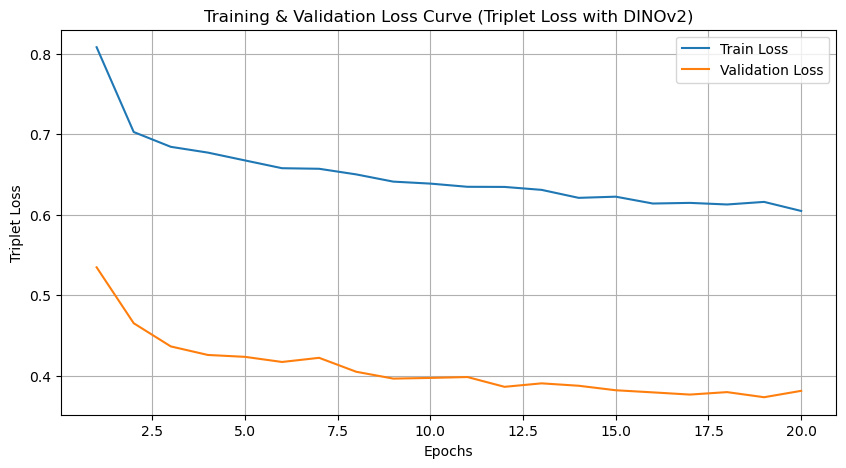

In [11]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,5))

plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Triplet Loss")
plt.title("Training & Validation Loss Curve (Triplet Loss with DINOv2)")
plt.legend()
plt.grid(True)

plt.show()

# 6.0 Feature Extraction

In [12]:
# --- 8. Feature Extraction ---

def extract_embeddings(model, data_loader, device):
    """Extracts embeddings and corresponding labels for a given dataset."""
    model.eval()
    embeddings_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels, _ in tqdm(data_loader, desc="Extracting Embeddings"):
            images = images.to(device)
            embeddings = model(images).cpu().numpy()
            
            embeddings_list.append(embeddings)
            labels_list.append(labels.cpu().numpy())

    return np.concatenate(embeddings_list), np.concatenate(labels_list)

# Extract Embeddings for Training and Testing
print("\nExtracting Training Embeddings...")
X_train_embed, y_train_labels = extract_embeddings(model, train_loader, DEVICE)

print("Extracting Test Embeddings...")
X_test_embed, y_test_labels = extract_embeddings(model, test_loader, DEVICE)

print(f"Train embeddings shape: {X_train_embed.shape}")
print(f"Test embeddings shape: {X_test_embed.shape}")


Extracting Training Embeddings...


Extracting Embeddings:   0%|          | 0/208 [00:00<?, ?it/s]

Extracting Test Embeddings...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

Train embeddings shape: (12480, 256)
Test embeddings shape: (207, 256)


# 7.0 KNN Classifier Training and Evaluation

In [13]:
# --- 9. KNN Classifier Training & Evaluation ---

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import top_k_accuracy_score
import numpy as np

def evaluate_subsets(classifier, X_embed, y_labels, with_pairs_classes, without_pairs_classes, all_classes, num_classes):
    """Evaluates Top-K accuracy on overall and subsets of the test set."""

    # Map original class IDs to 0-based indices for filtering
    idx_with_pairs = {CLASS_TO_IDX[cid] for cid in with_pairs_classes if cid in CLASS_TO_IDX}
    idx_without_pairs = {CLASS_TO_IDX[cid] for cid in without_pairs_classes if cid in CLASS_TO_IDX}

    # --- KNN does NOT output decision_function ---
    # Instead we use predict_proba (requires probability=True)
    y_scores = classifier.predict_proba(X_embed)

    results = {}

    # --- Helper for subset evaluation ---
    def compute_accuracy(scores, true_labels, subset_mask, labels_range):
        if not np.any(subset_mask):
            return 0.0, 0.0, 0

        subset_scores = scores[subset_mask]
        subset_labels = true_labels[subset_mask]

        top1_acc = top_k_accuracy_score(subset_labels, subset_scores, k=1, labels=labels_range)
        top5_acc = top_k_accuracy_score(subset_labels, subset_scores, k=5, labels=labels_range)

        return top1_acc, top5_acc, len(subset_labels)

    # --- Overall ---
    overall_mask = np.ones(len(y_labels), dtype=bool)
    top1, top5, count_all = compute_accuracy(
        y_scores, y_labels, overall_mask, np.arange(num_classes)
    )
    results["Overall"] = (top1, top5, count_all)

    # --- With Pairs ---
    mask_with_pairs = np.array([label in idx_with_pairs for label in y_labels])
    top1_wp, top5_wp, count_wp = compute_accuracy(
        y_scores, y_labels, mask_with_pairs, np.arange(num_classes)
    )
    results["Classes With Pairs"] = (top1_wp, top5_wp, count_wp)

    # --- Herbarium Only ---
    mask_without_pairs = np.array([label in idx_without_pairs for label in y_labels])
    top1_wo, top5_wo, count_wo = compute_accuracy(
        y_scores, y_labels, mask_without_pairs, np.arange(num_classes)
    )
    results["Classes Herbarium Only"] = (top1_wo, top5_wo, count_wo)

    return results


# --- Train KNN Classifier ---
print("\nTraining KNN Classifier (k=5)...")

classifier = KNeighborsClassifier(
    n_neighbors=5,        # You can tune this
    metric="euclidean",
    weights="distance",  # Better performance for embedding space
)

classifier.fit(X_train_embed, y_train_labels)

print("KNN Training complete.")

torch.save(classifier, os.path.join(BASE_DIR, "na_knn_classifier.pth"))
print("Saved KNN as knn_classifier.pth")

# --- Evaluation ---
results = evaluate_subsets(
    classifier,
    X_test_embed,
    y_test_labels,
    WITH_PAIRS_CLASSES,
    WITHOUT_PAIRS_CLASSES,
    ALL_SPECIES,
    NUM_CLASSES
)

print("\n--- Standard Test Set Results ---")
for key, (top1, top5, count) in results.items():
    print(f"| {key.ljust(30)} | Samples: {str(count).ljust(4)} | Top-1 Acc: {top1*100:.2f}% | Top-5 Acc: {top5*100:.2f}% |")



Training KNN Classifier (k=5)...
KNN Training complete.
Saved KNN as knn_classifier.pth

--- Standard Test Set Results ---
| Overall                        | Samples: 207  | Top-1 Acc: 42.03% | Top-5 Acc: 60.39% |
| Classes With Pairs             | Samples: 153  | Top-1 Acc: 52.29% | Top-5 Acc: 72.55% |
| Classes Herbarium Only         | Samples: 54   | Top-1 Acc: 12.96% | Top-5 Acc: 25.93% |


# 8.0 Test-Time Augmentation (TTA) for KNN

In [14]:
# --- 10. Test-Time Augmentation (TTA) for KNN ---

def extract_embeddings_with_transform(model, df, transform, batch_size, device):
    """Extracts embeddings using a specified transform (used for TTA)."""
    tta_dataset = PlantDataset(df, transform_inf=transform, is_train=False)
    tta_loader = DataLoader(
        tta_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    X_embed, y_labels = extract_embeddings(model, tta_loader, device)
    return X_embed, y_labels


def predict_with_tta(model, test_df, classifier, num_tta=5, device=DEVICE):
    """
    TTA using KNN (average probability scores across TTA passes).
    """
    
    tta_transform = FIELD_AUGMENT  
    all_tta_scores = []

    print(f"\nStarting TTA with {num_tta} passes...\n")

    for t in range(num_tta):
        print(f"  -> Running TTA pass {t+1}/{num_tta}...")

        # Different seed = different augmentations
        torch.manual_seed(42 + t)
        random.seed(42 + t)
        np.random.seed(42 + t)

        # 1. Extract embeddings with augmentation
        X_tta_embed, y_tta_check = extract_embeddings_with_transform(
            model, test_df, tta_transform, BATCH_SIZE, device
        )

        # 2. KNN: predict_proba instead of decision_function
        tta_scores = classifier.predict_proba(X_tta_embed)
        all_tta_scores.append(tta_scores)

    # 3. Average probability scores
    avg_tta_scores = np.mean(all_tta_scores, axis=0)

    # Reset seeds
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    # Subset masks
    idx_with_pairs = {CLASS_TO_IDX[cid] for cid in WITH_PAIRS_CLASSES if cid in CLASS_TO_IDX}
    idx_without_pairs = {CLASS_TO_IDX[cid] for cid in WITHOUT_PAIRS_CLASSES if cid in CLASS_TO_IDX}

    mask_with_pairs = np.array([label in idx_with_pairs for label in y_test_labels])
    mask_without_pairs = np.array([label in idx_without_pairs for label in y_test_labels])

    # ---- Top-K Accuracy Computation ----
    tta_top1 = top_k_accuracy_score(y_test_labels, avg_tta_scores, k=1, labels=np.arange(NUM_CLASSES))
    tta_top5 = top_k_accuracy_score(y_test_labels, avg_tta_scores, k=5, labels=np.arange(NUM_CLASSES))

    tta_top1_wp = top_k_accuracy_score(y_test_labels[mask_with_pairs], avg_tta_scores[mask_with_pairs], k=1, labels=np.arange(NUM_CLASSES))
    tta_top5_wp = top_k_accuracy_score(y_test_labels[mask_with_pairs], avg_tta_scores[mask_with_pairs], k=5, labels=np.arange(NUM_CLASSES))

    tta_top1_wo = top_k_accuracy_score(y_test_labels[mask_without_pairs], avg_tta_scores[mask_without_pairs], k=1, labels=np.arange(NUM_CLASSES))
    tta_top5_wo = top_k_accuracy_score(y_test_labels[mask_without_pairs], avg_tta_scores[mask_without_pairs], k=5, labels=np.arange(NUM_CLASSES))

    # ---- Print Results ----
    print("\n--- TTA Test Set Results (KNN + Probability Averaging) ---")
    print(f"| {'Overall'.ljust(30)} | Samples: {len(y_test_labels):4d} | Top-1 Acc: {tta_top1*100:.2f}% | Top-5 Acc: {tta_top5*100:.2f}% |")
    print(f"| {'Classes With Pairs'.ljust(30)} | Samples: {sum(mask_with_pairs):4d} | Top-1 Acc: {tta_top1_wp*100:.2f}% | Top-5 Acc: {tta_top5_wp*100:.2f}% |")
    print(f"| {'Classes Herbarium Only'.ljust(30)} | Samples: {sum(mask_without_pairs):4d} | Top-1 Acc: {tta_top1_wo*100:.2f}% | Top-5 Acc: {tta_top5_wo*100:.2f}% |")

    return tta_top1, tta_top5, avg_tta_scores, y_test_labels


# --- RUN TTA ---
TTA_TOP1, TTA_TOP5, AVG_TTA_SCORES, Y_TEST_LABELS_FINAL = predict_with_tta(
    model, TEST_DF, classifier, num_tta=5, device=DEVICE
)



Starting TTA with 5 passes...

  -> Running TTA pass 1/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 2/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 3/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 4/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 5/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]


--- TTA Test Set Results (KNN + Probability Averaging) ---
| Overall                        | Samples:  207 | Top-1 Acc: 43.96% | Top-5 Acc: 71.50% |
| Classes With Pairs             | Samples:  153 | Top-1 Acc: 52.94% | Top-5 Acc: 81.70% |
| Classes Herbarium Only         | Samples:   54 | Top-1 Acc: 18.52% | Top-5 Acc: 42.59% |


# 9.0 Evaluation 


--- Visualizing 5 Random Test Predictions ---


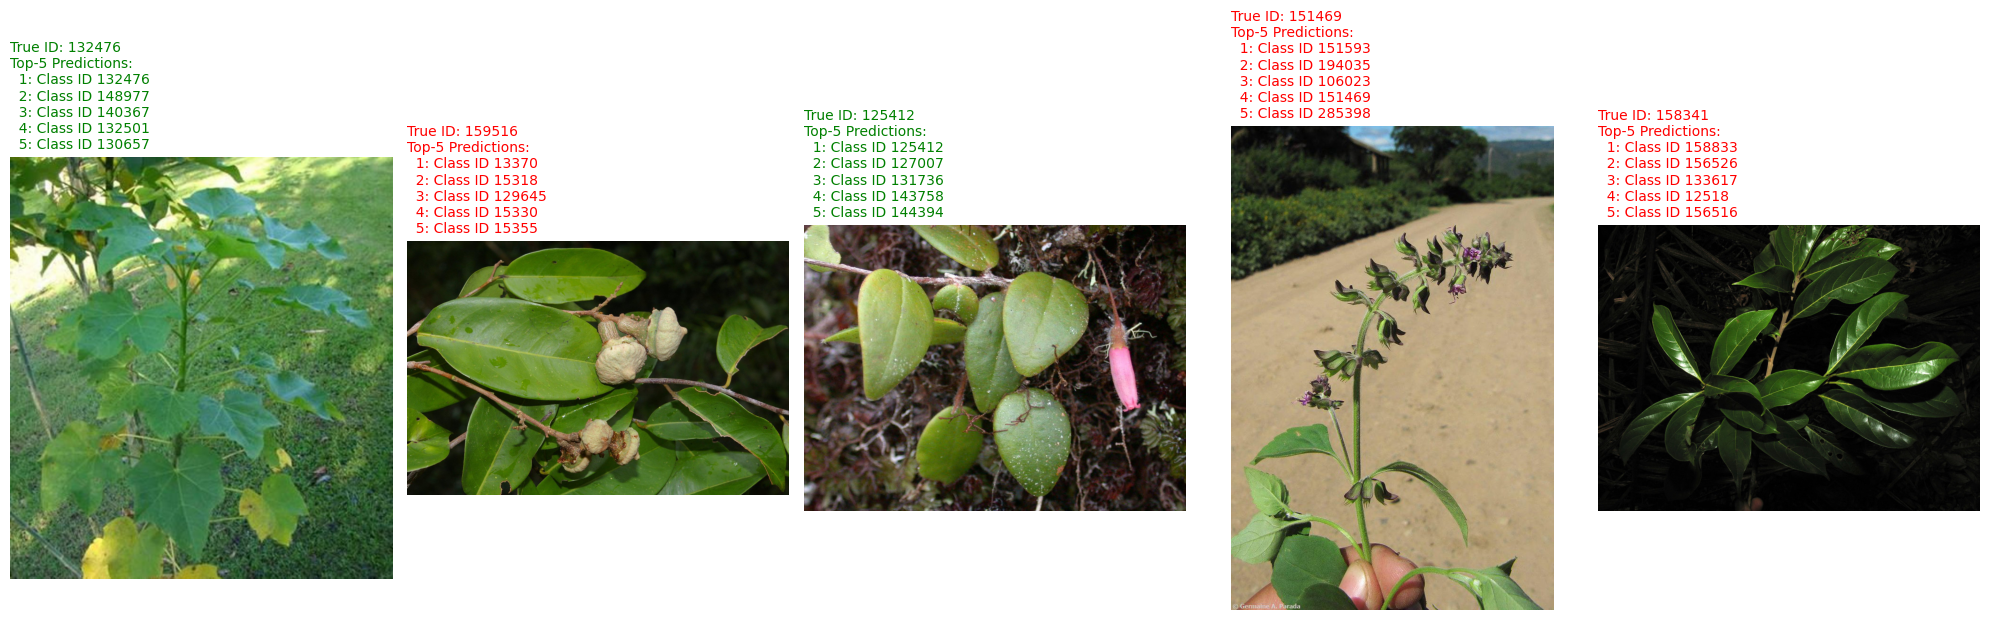

In [ ]:
# --- 11. Prediction Visualization ---

def visualize_predictions(test_df, y_true_idx, avg_scores, idx_to_class_map, num_samples=5):
    """
    Selects random test samples, displays the image, and shows the Top-5 predictions 
    based on the TTA-averaged scores.
    """
    
    print(f"\n--- Visualizing {num_samples} Random Test Predictions ---")
    
    # 1. Get the indices of the samples to visualize
    sample_indices = random.sample(range(len(test_df)), num_samples)
    
    # 2. Determine Top-K Predictions (Top-5)
    # The scores are in decision_function output, where larger values are closer/better.
    # We use np.argsort to get indices that would sort the scores.
    # [::-1] reverses the order to get the indices corresponding to the highest scores.
    # The result is the 0-based index labels (0 to NUM_CLASSES-1)
    top_k = 5
    predicted_indices = np.argsort(avg_scores, axis=1)[:, ::-1][:, :top_k]

    # Set up the plot
    fig, axes = plt.subplots(1, num_samples, figsize=(4 * num_samples, 6))
    if num_samples == 1:
        axes = [axes] # Ensure axes is iterable if only one sample

    for i, test_idx in enumerate(sample_indices):
        ax = axes[i]
        
        # Get ground truth (mapped to original class ID)
        true_idx = y_true_idx[test_idx]
        true_class_id = idx_to_class_map[true_idx]
        
        # Get image path
        img_path = test_df.iloc[test_idx]['path']
        img = Image.open(img_path).convert('RGB')
        
        # Get predictions (mapped to original class IDs)
        top_5_indices = predicted_indices[test_idx]
        top_5_class_ids = [idx_to_class_map[idx] for idx in top_5_indices]
        
        # Display Image
        ax.imshow(img)
        ax.axis('off')

        # Generate prediction text
        pred_text = "\n".join([
            f"  {k+1}: Class ID {cid}" for k, cid in enumerate(top_5_class_ids)
        ])
        
        # Set title color based on prediction accuracy
        is_correct = (top_5_class_ids[0] == true_class_id)
        title_color = 'green' if is_correct else 'red'

        # Final Title
        title = f"True ID: {true_class_id}\n"
        title += "Top-5 Predictions:\n"
        
        # Append the prediction text
        title += pred_text
        
        ax.set_title(title, fontsize=10, color=title_color, loc='left', ha='left')
        
    plt.tight_layout()
    plt.show()


# Execute Visualization (e.g., visualize 5 random samples)
visualize_predictions(
    TEST_DF, 
    Y_TEST_LABELS_FINAL, 
    AVG_TTA_SCORES, 
    IDX_TO_CLASS, 
    num_samples=5
)